# Predicting Housing Prices

Chi Zhang

While working on this project, I studied multiple sources of materials such as:

1, Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow, 2nd Edition

2, Stacked Regressions to Predict House Prices by Serigne
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

### Background

The task is to build machine learning modesl to predict house sale prices in Ames, Iowa. Home sellers can then use it as a benchmark tool to better price their houses, and home buyers can also get a better understadning on what factors to consider when looking at house prices.

### Framing the problem

It's a typical supervised learning task and we are given labled training examples. Since we are predicting a value using the variables provided, this is then a multiple regression problem. There is no continuous flow of data coming into the system, and the data is small enough to fit in memory, so plain batch learning should do it.

### Perfromance Measure
Here I will use RMSE to measure the performance of this regression task, and it will put more weights on large errors compared to MAE (Mean Absolute Erros).

### Load the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, RandomizedSearchCV, GridSearchCV, \
train_test_split, KFold
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### Data Preprocessing 

#### Convert the Datatypes 

In [7]:
data.drop('Id', axis = 1, inplace = True) 
data['MSSubClass'] = data['MSSubClass'].astype(str) 

# second iteration converting more datatypes
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
data['YearBuilt'] = data['YearBuilt'].astype(str)
data['YearRemodAdd'] = data['YearRemodAdd'].astype(str)
data['GarageYrBlt'] = data['GarageYrBlt'].astype(str)

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
year_mo_cat_lst = ['YrSold', 'MoSold', 'YearBuilt', 'YearRemodAdd','GarageYrBlt']

In [6]:
data['GarageYrBlt'].value_counts()

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1908.0     1
1927.0     1
1933.0     1
1900.0     1
1906.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

In [8]:
data_cat = data.select_dtypes(exclude = numerics)

for i in data_cat.columns:
    data[i] = data[i].fillna("None")

In [9]:
data.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,...,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,24.284752,9981.264932,1.382997,1.112799,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,...,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,59.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,...,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,...,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,80.000000,11601.500000,7.000000,6.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,...,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


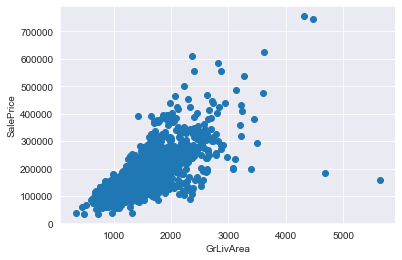

In [10]:
# Assuming living area square feet is an important factor determing the sale price

sns.set_style('darkgrid')
plt.plot(data['GrLivArea'], data['SalePrice'], 'o')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice');

Form the scatter plot, we see living area is positively correlated with sale prices. There are two outliers with large livgin areas and low sales price, and it's safe to delete those two records. 

In [11]:
# deleting outliers
outliers = data[(data['GrLivArea'] > 4000) & (data['SalePrice'] < 200000)]
data = data.drop(outliers.index, axis = 0)
data.reset_index(inplace = True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 81 columns):
index            1458 non-null int64
MSSubClass       1458 non-null object
MSZoning         1458 non-null object
LotFrontage      1199 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null object
Alley            1458 non-null object
LotShape         1458 non-null object
LandContour      1458 non-null object
Utilities        1458 non-null object
LotConfig        1458 non-null object
LandSlope        1458 non-null object
Neighborhood     1458 non-null object
Condition1       1458 non-null object
Condition2       1458 non-null object
BldgType         1458 non-null object
HouseStyle       1458 non-null object
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null object
YearRemodAdd     1458 non-null object
RoofStyle        1458 non-null object
RoofMatl         1458 non-null object
Exterior1st      1458 

Now we will study the target variable: sale price

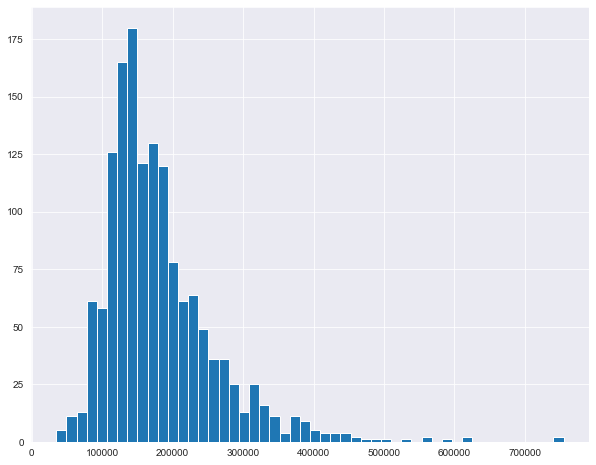

In [13]:
# The distribution of the target: sale price
data['SalePrice'].hist(bins=50, figsize=(10,8))
plt.show()

From the histogram, we see that sales price is rightly skewed, and we will need to transform it to fit better for linear models

In [14]:
data['SalePrice'] = np.log(data['SalePrice'])  # 2nd interation 

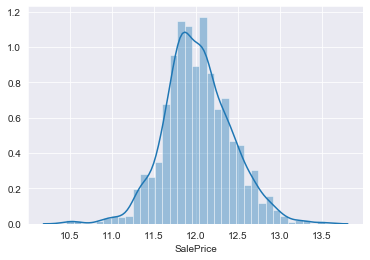

In [15]:
#Check the new distribution 
sns.distplot(data['SalePrice']);

Now the our target variable is normally ditributed. 

### Create a Test Set
Here we will use stratified sampling to create a test set to avoid sampling bias. Knowing that the type of dwelling plays an import role in determing the price, we split the test set based on the distribution of MSSubclass. 

In [16]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["MSSubClass"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

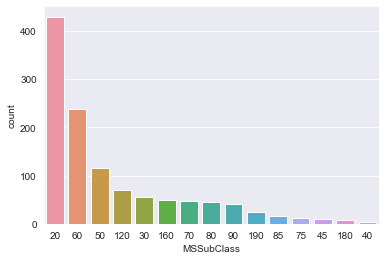

In [17]:
# check the ditribution:
#strat_train_set['MSSubClass'].value_counts()/len(strat_train_set)
sns.countplot(strat_train_set['MSSubClass'], order = strat_train_set['MSSubClass'].value_counts().index);

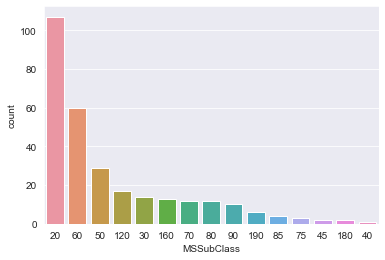

In [18]:
#strat_test_set['MSSubClass'].value_counts()/len(strat_test_set)
sns.countplot(strat_test_set['MSSubClass'], order = strat_train_set['MSSubClass'].value_counts().index);

Fromt the two barplots, test and training sets follow a similar distribution in terms of MSSubClass 

### Data Preperation for ML

In [19]:
housing = strat_train_set.drop("SalePrice", axis=1)
housing_labels = strat_train_set["SalePrice"].copy().reset_index(drop = True)

In [20]:
# Checking the missing values 
perc_missing = (housing.isnull().sum()/housing.shape[0])*100
perc_missing.drop(perc_missing[perc_missing == 0].index).sort_values(ascending = False)
# There are two variables which have missing values needed to be imputed 

LotFrontage    18.267581
MasVnrArea      0.600343
dtype: float64

In [21]:
# select the numeric variables
housing_num = housing.select_dtypes(include=numerics)
housing_num

,index,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
1144,1145,52.0,6240,5,6,0.0,0,0,1042,1042,...,1,1,225,0,0,0,0,0,0,0
1297,1299,75.0,7500,5,7,0.0,340,906,0,1246,...,0,1,305,218,0,0,0,0,0,0
426,426,NaN,12800,7,5,145.0,1518,0,0,1518,...,1,2,569,80,0,0,0,396,0,0
1448,1450,60.0,9000,5,5,0.0,0,0,896,896,...,0,0,0,32,45,0,0,0,0,0
504,504,24.0,2308,6,5,0.0,257,495,103,855,...,1,2,440,260,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,1268,NaN,14100,8,9,632.0,192,0,536,728,...,2,3,1014,314,12,0,0,0,0,0
1146,1147,75.0,12000,7,7,0.0,275,0,429,704,...,1,1,234,0,0,0,0,0,0,0
280,280,82.0,11287,7,6,340.0,421,0,386,807,...,1,2,575,0,84,0,196,0,0,0
681,682,NaN,2887,6,5,0.0,1003,0,288,1291,...,1,2,431,307,0,0,0,0,0,0


In [22]:
# Building a pipeline for feature engineering
Bedrooms, firstfloor_sf, total_rooms, above_sf, basement_sf = int(housing_num.columns.get_loc('BedroomAbvGr')), \
                                                int(housing_num.columns.get_loc('1stFlrSF')), \
                                                int(housing_num.columns.get_loc('TotRmsAbvGrd')), \
                                                int(housing_num.columns.get_loc('GrLivArea')),\
                                                int(housing_num.columns.get_loc('TotalBsmtSF'))
class EngineeredFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, add_features = True):
        self.add_features = add_features
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        if self.add_features:
            total_area = X[:, above_sf] + X[:,basement_sf] # second iteration new feature
            firstfl_per = X[:, firstfloor_sf] / total_area
            bedroom_per = X[:, Bedrooms] / X[:, total_rooms]
            return np.c_[X, total_area, firstfl_per, bedroom_per]
        else:
            return X

In [23]:
## Create a transformation pipiline for numeric attributes
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('feature_engin', EngineeredFeatures()),
        ('std_scaler', StandardScaler()),
    ])

In [24]:
# Creating a list of categorical varibales exluding the year/month related ones
housing_cat = housing.select_dtypes(exclude=numerics)
col_names_cat = housing_cat.columns.drop(year_mo_cat_lst)
col_names_cat

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [25]:
# Use ColumnTransformer to combine numerical and categorical, and output prepared dataset

num_attribs = list(housing_num.columns)
cat_attribs = list(housing_cat)
#year_attribs = list(year_mo_cat_lst)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), # use numerica pipeline built for numerical attributes
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs) # one hot encoding for categorical variables
       # ('year', OrdinalEncoder(), year_attribs), # ordinal encoding for year month variables 
    ])

housing_prepared = full_pipeline.fit_transform(housing)

### Train & Evaluate Models

In [ ]:
predictions = dt.predict(housing_prepared)
mse = mean_squared_error(housing_labels, predictions)
rmse = np.sqrt(mse)
rmse ## overfit

In [27]:
def display_scores(scores):
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [28]:
# 5 fold CV for linear regression 
reg = LinearRegression()
reg.fit(housing_prepared, housing_labels)
scores_LR = cross_val_score(reg, housing_prepared, housing_labels,
                         scoring='neg_root_mean_squared_error', cv=5)
display_scores(-scores_LR)  

Mean: 0.1924973221883881
Standard deviation: 0.011671521290402349


We use linear regression as our baseline model, and then we will use different techniques to improve on the score. 

In [29]:
# 5 fold CV for Lasso regression to avoid overfitting

lasso = Lasso(alpha =0.001)
scores_Lasso = cross_val_score(lasso, housing_prepared, housing_labels,
                         scoring='neg_root_mean_squared_error', cv=5)
display_scores(-scores_Lasso)  

Mean: 0.11696717770020296
Standard deviation: 0.010454192820794166


In [30]:
# 5 fold CV for Ridge regression to avoid overfitting

ridge = Ridge(alpha =0.001)
scores_Ridge = cross_val_score(ridge, housing_prepared, housing_labels,
                         scoring='neg_root_mean_squared_error', cv=5)
display_scores(-scores_Ridge)  

Mean: 0.1666865853681596
Standard deviation: 0.01104057742374339


In [31]:
## Cross Validation
dt = DecisionTreeRegressor()
dt.fit(housing_prepared, housing_labels)
scores_DT = cross_val_score(dt, housing_prepared, housing_labels,
                         scoring='neg_root_mean_squared_error', cv=5)
display_scores(-scores_DT) # for decision tree model 

Mean: 0.21040827938559548
Standard deviation: 0.012422330326047329


In [33]:
rf = RandomForestRegressor()
scores_RF = cross_val_score(rf, housing_prepared, housing_labels,
                         scoring='neg_root_mean_squared_error', cv=5, n_jobs = -1)
display_scores(-scores_RF) # for random forest model 

Mean: 0.14389494702273092
Standard deviation: 0.013682413606328188


### Fine Tune Models
Next we will fine tune the hyperparameters to improve the performance of RF

In [34]:
# Random Grid: 
# number of trees in rf
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features at every split
max_features = [50, 100, 150]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [35]:
random_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, \
                               cv = 5, random_state=42, n_jobs = -1, scoring='neg_root_mean_squared_error')
random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [36]:
random_search.best_params_

{'n_estimators': 325,
 'max_features': 100,
 'max_depth': 110,
 'bootstrap': False}

In [38]:
best_rf_rs = random_search.best_estimator_
scores_best_rf = cross_val_score(best_rf_rs, housing_prepared, housing_labels,
                         scoring='neg_root_mean_squared_error', cv=5, n_jobs = -1)
display_scores(-scores_best_rf) 

Mean: 0.13412098232366626
Standard deviation: 0.010762162307689099


#### Grid Search
Once we have used random search to narrow down the range of each hyperparameter, we then look at specific combinations using grid search

In [ ]:
# Setting up grid search 
param_grid = [
    {'bootstrap': [False], 'n_estimators': [300, 400, 500], 'max_features': [100, 110], 'max_depth': [110, 120]}
  ]

grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True,
                           n_jobs = -1)

grid_search.fit(housing_prepared, housing_labels)

In [ ]:
best_rf_gs = grid_search.best_estimator_
scores_best_rf_gs = cross_val_score(best_rf_gs, housing_prepared, housing_labels,
                         scoring='neg_root_mean_squared_error', cv=5, n_jobs = -1)
display_scores(-scores_best_rf_gs) # for random forest model 

The updates on hyperparameters via grid search further imporves the performance of the model.

### Analyze the Results of the Best Model

In [40]:
feature_importance = best_rf_rs.feature_importances_

In [41]:
new_features = ['Total_area', 'FirstFL_perc', 'Bedroom_perc']
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + new_features + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse = True)

[(0.168770777554783, 'Total_area'),
 (0.14591535506850295, 'OverallQual'),
 (0.10606488083019988, 'GrLivArea'),
 (0.045847343235818544, 'GarageCars'),
 (0.03820278706688514, 'GarageArea'),
 (0.033904759563173, 'TotalBsmtSF'),
 (0.030013931754631767, 'FullBath'),
 (0.021631514268921175, '1stFlrSF'),
 (0.01452361646054082, 'LotArea'),
 (0.012100022742964138, '2ndFlrSF'),
 (0.011839669178259953, 'Fireplaces'),
 (0.011804481807304883, 'BsmtFinSF1'),
 (0.0061351694617904195, 'OpenPorchSF'),
 (0.006083042960233776, 'LotFrontage'),
 (0.005923653053538011, 'OverallCond'),
 (0.005657330808084111, 'BsmtUnfSF'),
 (0.0050332299979828415, 'TotRmsAbvGrd'),
 (0.004783938332836879, 'MasVnrArea'),
 (0.004727293410111344, 'FirstFL_perc'),
 (0.004662575949956241, '60'),
 (0.004009967107026139, 'Bedroom_perc'),
 (0.0033597116709844278, 'index'),
 (0.0025618839372666745, 'BedroomAbvGr'),
 (0.0024572101302983273, 'WoodDeckSF'),
 (0.002239563246711688, 'KitchenAbvGr'),
 (0.001850581352729182, 'BsmtFullBath')

### Creating stacking ensemble model to imporve performance

In [42]:
class StackingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5): # using 5 folds to create hold out set to train a blender
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        """
        Take input training featers and lables to first, fit and generate predictions for original models. Second, 
        fit the blender model with predictions and lables
        """
        self.base_models_ = [list() for x in self.base_models] # creating empty list for each model
        self.meta_model_ = clone(self.meta_model) # make a copy for the blender model 
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state = 1) # 5 folds to split the dataset
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))# create matrix to store predictions
        
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance) # append the first instance to the model 1 list
                instance.fit(X[train_index], y[train_index])# fit the model with assined training set
                y_pred = instance.predict(X[holdout_index])# generate prediction with test set 
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the blender model using the predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack(
                                        [np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
                                            for base_models in self.base_models_ ]
                                        ) # create features the blender model as mean of each instance of each base model
        return self.meta_model_.predict(meta_features)

In [46]:
stacked_averaged_models = StackingModels(base_models = (best_rf_rs, reg, ridge),
                                                 meta_model = lasso)
stacked_averaged_models.fit(housing_prepared, housing_labels)
predictions = stacked_averaged_models.predict(housing_prepared)
mse = mean_squared_error(housing_labels, predictions)
rmse = np.sqrt(mse)
rmse

0.03613658354269214

THe stacking model is the best so far, and is decrese the rmse by 80% compared to the baseline model. 

### Evaluate the Model on the Test Set

In [47]:
test_model = stacked_averaged_models
# Split test data to atttributes and labels
X_test = strat_test_set.drop("SalePrice", axis=1)
y_test = strat_test_set["SalePrice"].copy().reset_index(drop =True)

# apply the data transformation pipeline on test data 
X_test_prepared = full_pipeline.transform(X_test)

# run final model on the prepared dataset
final_predictions = test_model.predict(X_test_prepared)

# calculate RMSE on test set
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [48]:
final_rmse

0.12316600634274295

In [49]:
squared_errors = (final_predictions - y_test) ** 2
# 95% confidence interval of the mean RMSE
np.sqrt(stats.t.interval(0.95, len(squared_errors) - 1, loc = squared_errors.mean(), scale = stats.sem(squared_errors)))

array([0.10319659, 0.14032175])

### Conclusion

This project follows an iterative process, the goal is to create the most accurate model to predict the sale price of a house. 
I started with fixing datatypes, safely deleting outliers and transforming vairables to better fit for linear models.(EDA)
Next I build pipelines to preprocess data automatically including imputing and scaling numeric variables, encoding categorical variables and feature engineering.
Once the dataset is prepared for machine learning models, I first built a linear regression as the baseline model. Next, I built a sequence of models with the same cross validation and evaluation metric inluding lass & ridge regression, decision tree and random forest. Then I applied both random search and grid search to fine tune hyperparameters and came up with the best model. Random Forest also provides us feature importance which shows that total areas, areas above the ground, overall quality, garage areas being the top factoring determing the sale price. 
Lastyly, I built a stacking model to further improve the performance. In terms of the results, it decreases the RMSE by 80% compared to the baseline model. 